In [1]:
using Plots

n,p = 1000, 0.51
a,b = 1,1
f = 0.1

function gain(f,n=n, p=p, a=1,b=1)
    gains = cumsum(rand(n).<p)
    trials = 1:n
    fac = ((1 + f*a) / (1 - f*b)).*ones(n) 
    ret = fac.^gains
    return ret .* ( (1 - f*b).^trials )
end


R(f, p, a, b) = (1 + f*a)^p * (1 - f*b)^(1-p)
f_kelly(p,a,b) = p/b - (1-p)/a

f_kelly (generic function with 1 method)

In [2]:
n,N = 100, 50
p,a,b = 0.7,1,1
f_list = 0.02:0.01:0.98

function samples(f,p,a,b)
    A = zeros(n,N)
    for i in 1:N
        A[:,i] = gain(f,n,p,a,b)
    end
    return A
end

D = Dict()
for f in f_list
    D[f] = samples(f,p,a,b)
end

In [3]:
using Plots; gr()
l = @layout [a{0.95w} b]
cmap = cgrad(:curl)
p1 = plot(
    yscale = :log,
    xlabel="time t", 
    ylabel = "gain (log scale)", 
    xticks=0:10:100,
    yticks=[1e-10,1e-5, 1e0, 1e5],
    colorbar=:best,
    cbar=true, 
    title="Gambling gains over time (p = $p)", 
    foreground_color=:white, 
    background_color=:gray30)
for f in f_list
    #plot!(p1, D[f][:,1:10], alpha=0.1, seriestype=:steppost, color=cmap[f],label=:none)
    plot!(p1, sum(D[f],dims=2)/N, color=cmap[f], seriestype=:steppost,alpha=0.8,cbar=true,label=:none)
end
p2 = heatmap(rand(2,2), clims=(0,1), framestyle=:none, c=cmap, cbar=true, lims=(-1,0), colorbar_title="investment fraction f")
plot(p1, p2, layout=l)
savefig("kellygains.png")

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/home/coste/Documents/simulations/kellygains.png"

In [4]:
function mean_floored(v)
    m = sum(v)./size(v)[1]
    ( isnan(m) || m<=1e-30 ) ? 1e-30 : m
end
M = [mean_floored(D[f][end,:]) for f in f_list];
using Statistics
σ = [std(D[f][end,:]) for f in f_list];

In [5]:
using Distributions
P = Binomial(n,p)
qsimple(δ) = quantile(P, 1 - δ)
qmax(m, δ = 0.1) = quantile(P, (1 - δ)^(1/m))
function maxgain(f,m,n,p)
    k = qmax(m)
    ((1 - f)^(n-k)) * (1+f)^k
end
M3 = maxgain.(f_list, N, n, p);

In [6]:
function mean_2(f,n,N,p,a=1,b=1)
    q = qmax(N)
    st = sqrt(n/(q*(n-q))) / sqrt(2*pi) * ((n/(n-q))^n) * (((n-q)/q)^q)   # Stirling's approx of binomial(n,t)
    (((1-p)*(1-f*b))^(n-q)) * ((p*(1 + f*a))^q) * st 
end

M2 = mean_2.(f_list, n,N,p)

97-element Vector{Float64}:
    0.004404427065354719
    0.008314593334008647
    0.015545690003339788
    0.028790220589124234
    0.05281924728543671
    0.09600537603454053
    0.1729006595751272
    0.30855662690886876
    0.5456917755493281
    0.9564653292307399
    ⋮
 1643.541818483645
  423.7639633117799
   88.25994266240674
   14.033151299159792
    1.5680023904788716
    0.1082915815703796
    0.0037282553941345533
    4.27553022917988e-5
    6.606213387044649e-8

In [10]:
function g(f,p,a,b,n)
    gamma = (1 + f*a) / (1 - f*b)
    (1 - f*b)^n * gamma^(n*p) + 2
end

N_plot = Int(min(N,1000))

vline([f_kelly(p,a,b)], color=:gray, lw=4, label="kelly's optimum")

for f in f_list
    _label = f == f_list[1] ? "simulations of gains (N=$N runs)" : :none
    scatter!(f.*ones(N_plot), 
    D[f][end,1:N_plot], 
    color=:lightsalmon, 
    alpha=0.2, ms=2, 
    label=_label, 
    markerstrokewidth=0,
    foreground_color=:white, 
    background_color=:gray30)
end
#plot!(f_list, M3, fillrange=1e-20, label = "statistical maximal gain (1-δ = 99%)", color=:gray, alpha=0.3)
plot!(yscale=:log, ylims=(1e-20, 1e20), legend=:bottomleft)
plot!(ylims=(1e-20,1e20))
e = p*a - (1-p)*b
plot!(f_list, (1 .+ e.*f_list).^n , lw=2, label="dummy gain (1 + f*e)^n")
plot!(f_list, R.(f_list, p,a,b).^n, lw=2, label="kelly gain")

savefig("kellygains2.png")

"/home/coste/Documents/simulations/kellygains2.png"

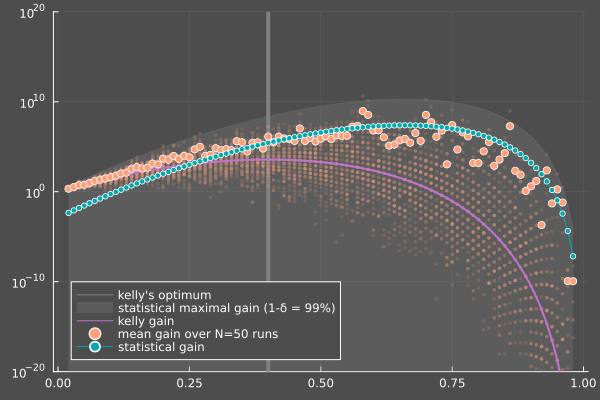

In [8]:

vline([f_kelly(p,a,b)], color=:gray, lw=4, label="kelly's optimum")
for f in f_list
    scatter!(f.*ones(N_plot), D[f][end,1:N_plot], color=:lightsalmon, alpha=0.2, ms=2, label=:none, markerstrokewidth=0)
end
plot!(f_list, M3, fillrange=1e-20, label = "statistical maximal gain (1-δ = 99%)", color=:gray, alpha=0.3)
plot!(yscale=:log, ylims=(1e-20, 1e20), legend=:bottomleft,foreground_color=:white, 
    background_color=:gray30)
plot!(ylims=(1e-20,1e20))
e = p*a - (1-p)*b
plot!(f_list, R.(f_list, p,a,b).^n, lw=2, label="kelly gain")

scatter!(f_list, M, color=:lightsalmon, label="mean gain over N=$N runs")
#plot!(f_list, M .+ σ, fillrange = M.-σ, color=:gray, alpha=0.2)
plot!(f_list, M2, markersize=3, markershape=:circle, label="statistical gain")




In [22]:
n=100
r = 0.1*(rand(n) .- 0.5)
X(x) = sum(log.(1 .+ x .* r))

X (generic function with 1 method)

In [21]:
f_list

0.02:0.01:0.98

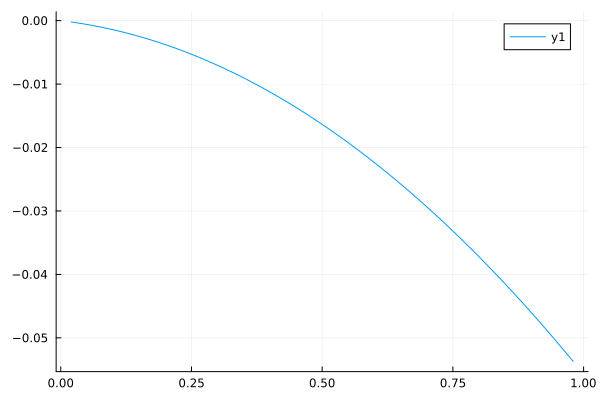

In [23]:
plot(f_list, X.(f_list))


In [26]:
using DataFrames, CSV

In [138]:
df = DataFrame(CSV.File("HistoricalPrices.csv"));
df2 = DataFrame(CSV.File("futures.csv"))

1401×7 DataFrame
  Row │ Date        Price     Open      High      Low       Vol.     Change % 
      │ String15    String15  String15  String15  String15  String7  String7  
──────┼───────────────────────────────────────────────────────────────────────
    1 │ 01/17/2023  4,006.00  4,013.25  4,034.75  4,000.75  822.16K  -0.19%
    2 │ 01/16/2023  4,013.50  4,013.00  4,027.50  3,997.00  153.56K  0.00%
    3 │ 01/15/2023  4,013.50  4,020.25  4,022.25  4,011.75  7.84K    -0.12%
    4 │ 01/13/2023  4,018.25  4,003.00  4,024.25  3,961.75  1.46M    0.37%
    5 │ 01/12/2023  4,003.50  3,991.75  4,021.50  3,954.00  2.10M    0.34%
    6 │ 01/11/2023  3,990.00  3,941.00  3,992.50  3,934.50  1.40M    1.25%
    7 │ 01/10/2023  3,940.75  3,914.50  3,943.75  3,891.50  1.52M    0.69%
    8 │ 01/09/2023  3,913.75  3,918.50  3,973.25  3,909.75  1.70M    -0.04%
  ⋮   │     ⋮          ⋮         ⋮         ⋮         ⋮         ⋮        ⋮
 1395 │ 10/27/2017  2,578.50  2,561.50  2,580.75  2,557.50  1.56M    0.66%
 1396 │ 10/26/2017  2,561.50  2,559.50  2,565.00  2,555.50  1.39M    0.12%
 1397 │ 10/25/2017  2,558.50  2,564.75  2,566.25  2,541.50  2.10M    -0.34%
 1398 │ 10/24/2017  2,567.25  2,562.50  2,570.25  2,562.25  1.05M    0.15%
 1399 │ 10/23/2017  2,563.50  2,572.75  2,577.25  2,561.50  1.27M    -0.41%
 1400 │ 10/20/2017  2,574.00  2,561.00  2,574.50  2,559.50  1.25M    0.53%
 1401 │ 10/19/2017  2,560.50  2,560.00  2,561.50  2,542.50  1.36M    0.02%
                                                             1386 rows omitted

In [169]:
function converse(st)
    st = replace(String(st), "," => "")
    return parse(Float32, st)
end
price_f = converse.(reverse(df2[:,"Price"]))
rets_f = price[2:end] ./ price[1:end-1] .- 1


1400-element Vector{Float32}:
  0.0052723885
 -0.0040792823
  0.0014628172
 -0.0034083128
  0.0011725426
  0.006636739
 -0.003975153
  0.0017521381
  0.0007773638
  0.00077676773
  ⋮
  0.022590756
 -0.00044691563
  0.006898761
  0.0124976635
  0.0033835173
  0.0036842823
 -0.0011820793
  0.0
 -0.0018686652

In [117]:
op = reverse(df[:, " Open"])
rets = op[2:end]./op[1:end-1] .- 1

1065-element Vector{Float64}:
 -0.0006196724382668828
 -0.019073952572874586
  0.006188832905186459
 -0.0230069360488262
 -0.002624416796267459
  0.00554376916329935
 -0.015644977913630287
  0.024584576699940852
  0.004427853341218313
  0.010255447861700517
  ⋮
  0.006383117646290737
 -0.003355574067874456
 -0.00016144319803357288
 -0.004263309494913714
  0.022872492068515493
 -0.0056893439227578835
  0.011258637493988699
  0.011499485040751711
 -0.004336818710921508

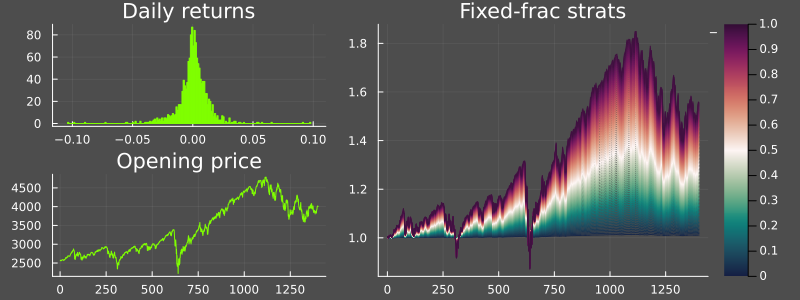

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [171]:
function plot_returns(a, b)
    p1 = plot(foreground_color=:white, 
        background_color=:gray30, 
        title="Daily returns", 
        legend=:none)
    histogram!(p1, b, nbins=200, color=:chartreuse, linecolor=:chartreuse)

    p2 = plot(a, label="price", color=:chartreuse)
    plot!(p2, title="Opening price", legend=:none)


    l = @layout [a{0.95w} b]
    cmap = cgrad(:curl)
    p3bis = plot(
        colorbar=:best,
        cbar=true, 
        title="Fixed-frac strats", 
        foreground_color=:white, 
        background_color=:gray30)
    for f in f_list
        plot!(p3bis, cumprod(1 .+ f .* b),label=:none, color=cmap[f])
    end
    colb = heatmap(rand(2,2), clims=(0,1), framestyle=:none, c=cmap, cbar=true, lims=(-1,0))
    p3 = plot(p3bis, colb, layout=l)
    #savefig("kellygains.png")

    ll = @layout [[a ; b ] c{0.6w}]
    plot(p1,p2,p3, layout=ll, size=(800,300))
end

plot_returns(price_f, rets_f)

In [172]:
price_f

1401-element Vector{Float32}:
 2560.5
 2574.0
 2563.5
 2567.25
 2558.5
 2561.5
 2578.5
 2568.25
 2572.75
 2574.75
    ⋮
 3915.5
 3913.75
 3940.75
 3990.0
 4003.5
 4018.25
 4013.5
 4013.5
 4006.0